In [1]:
%matplotlib inline

from pathlib import Path
import warnings
from random import randint
import joblib
from itertools import product

import numpy as np
import pandas as pd

import shap
import lightgbm as lgb
from sklearn.inspection import (plot_partial_dependence, partial_dependence)

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
idx = pd.IndexSlice
np.random.seed(42)
DATA_STORE = Path('data/assets.h5')

In [2]:
lgb.__version__

'3.3.3'

In [3]:
with pd.HDFStore('data/data.h5') as store:
    best_params = store['best_params']
best_params

train_length        1134.00
test_length           63.00
learning_rate          0.10
num_leaves             8.00
feature_fraction       0.95
min_data_in_leaf    1000.00
boost_rounds         500.00
Name: 1091, dtype: float64

In [4]:
# Get Training Data
data = pd.read_hdf('data/data.h5', 'model_data').sort_index()
data = data.loc[idx[:, '2013':'2018'], :]
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1205931 entries, ('A', Timestamp('2013-01-02 00:00:00')) to ('ZION', Timestamp('2017-12-29 00:00:00'))
Data columns (total 34 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   dollar_vol       1205931 non-null  float64
 1   dollar_vol_rank  1205931 non-null  float64
 2   rsi              1205931 non-null  float64
 3   bb_high          1205931 non-null  float64
 4   bb_low           1205930 non-null  float64
 5   NATR             1205931 non-null  float64
 6   ATR              1205931 non-null  float64
 7   PPO              1205931 non-null  float64
 8   MACD             1205931 non-null  float64
 9   sector           1205931 non-null  int32  
 10  r01              1205931 non-null  float64
 11  r05              1205931 non-null  float64
 12  r10              1205931 non-null  float64
 13  r21              1205931 non-null  float64
 14  r42              1205931 non-null  float6

In [5]:
# Create Binary Data
dates = sorted(data.index.get_level_values('date').unique())
train_dates = dates[-int(best_params.train_length):]
data = data.loc[idx[:, train_dates], :]
labels = sorted(data.filter(like='_fwd').columns)
features = data.columns.difference(labels).tolist()
lookahead = 1
label = f'r{lookahead:02}_fwd'
categoricals = ['year', 'month', 'sector', 'weekday']

lgb_train = lgb.Dataset(data=data[features], label=data[label], categorical_feature=categoricals,
                       free_raw_data=False)

In [6]:
# Train LightGBM Model
params = dict(boosting='gbdt', objective='regression', verbose=-1, num_threads=6, device_type='gpu')
train_params = ['learning_rate', 'num_leaves', 'feature_fraction', 'min_data_in_leaf']

params.update(best_params.loc[train_params].to_dict())

for p in ['min_data_in_leaf', 'num_leaves']:
    params[p] = int(params[p])

lgb_model = lgb.train(params=params, train_set=lgb_train, num_boost_round=int(best_params.boost_rounds))

In [7]:
params

{'boosting': 'gbdt',
 'objective': 'regression',
 'verbose': -1,
 'num_threads': 6,
 'device_type': 'gpu',
 'learning_rate': 0.1,
 'num_leaves': 8,
 'feature_fraction': 0.95,
 'min_data_in_leaf': 1000}

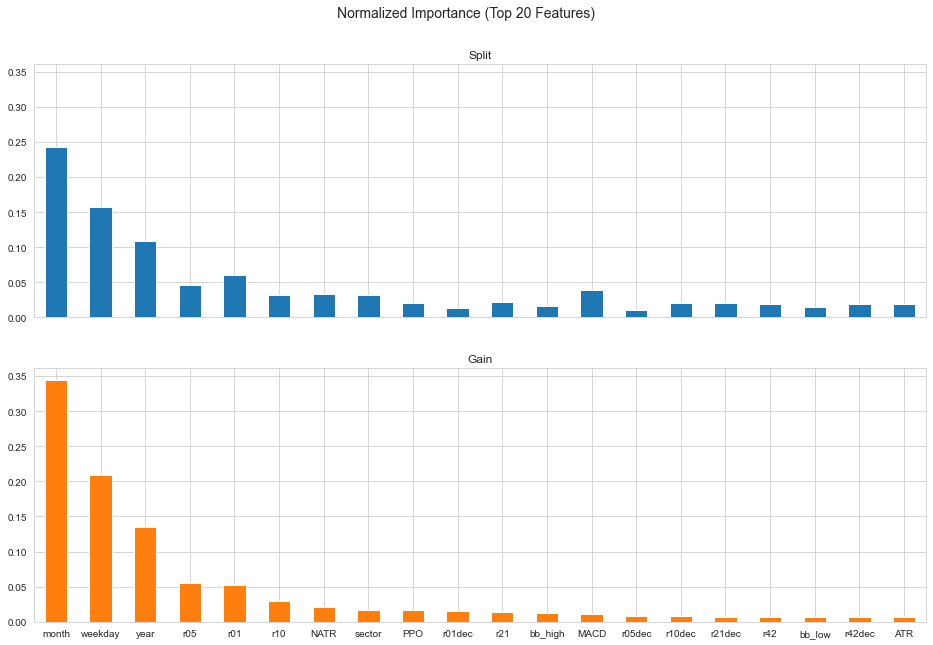

In [17]:
# Compute Feature Importance
def get_feature_importance(model, importance_type='split'):
    fi = pd.Series(model.feature_importance(importance_type=importance_type), index=model.feature_name())
    return fi/fi.sum()

feature_importance = (get_feature_importance(lgb_model).to_frame('Split').
                      join(get_feature_importance(lgb_model, 'gain').to_frame('Gain')))
(feature_importance.nlargest(20, columns='Gain').sort_values('Gain', ascending=False).plot
 .bar(subplots=True, layout=(2, 1), figsize=(16, 10), legend=False, sharey=True, rot=0))

plt.suptitle('Normalized Importance (Top 20 Features)', fontsize=14)
plt.subplots_adjust(top=.9);

In [9]:
# Partial Dependence Plots
class OneStepTimeSeriesSplit:
    pass

gb_clf = joblib.load('results/baseline/sklearn_gbm_model.joblib')

def get_data(start='2000', end='2018', holding_period=1, dropna=False):
    idx = pd.IndexSlice
    target = f'target_{holding_period}m'
    with pd.HDFStore(DATA_STORE) as store:
        df = store['engineered_features']

    if start is not None and end is not None:
        df = df.loc[idx[:, start: end], :]
    if dropna:
        df = df.dropna()

    y = (df[target] > 0).astype(int)
    X = df.drop([c for c in df.columns if c.startswith('target')], axis=1)
    return y, X

def factorize_cats(df, cats=['sector']):
    cat_cols = ['year', 'month', 'age', 'msize'] + cats
    for cat in cats:
        df[cat] = pd.factorize(df[cat])[0]
    df.loc[:, cat_cols] = df.loc[:, cat_cols].fillna(-1)
    return df

y_clean, features_clean = get_data(dropna=True)
X = factorize_cats(features_clean).drop(['year', 'month'], axis=1)

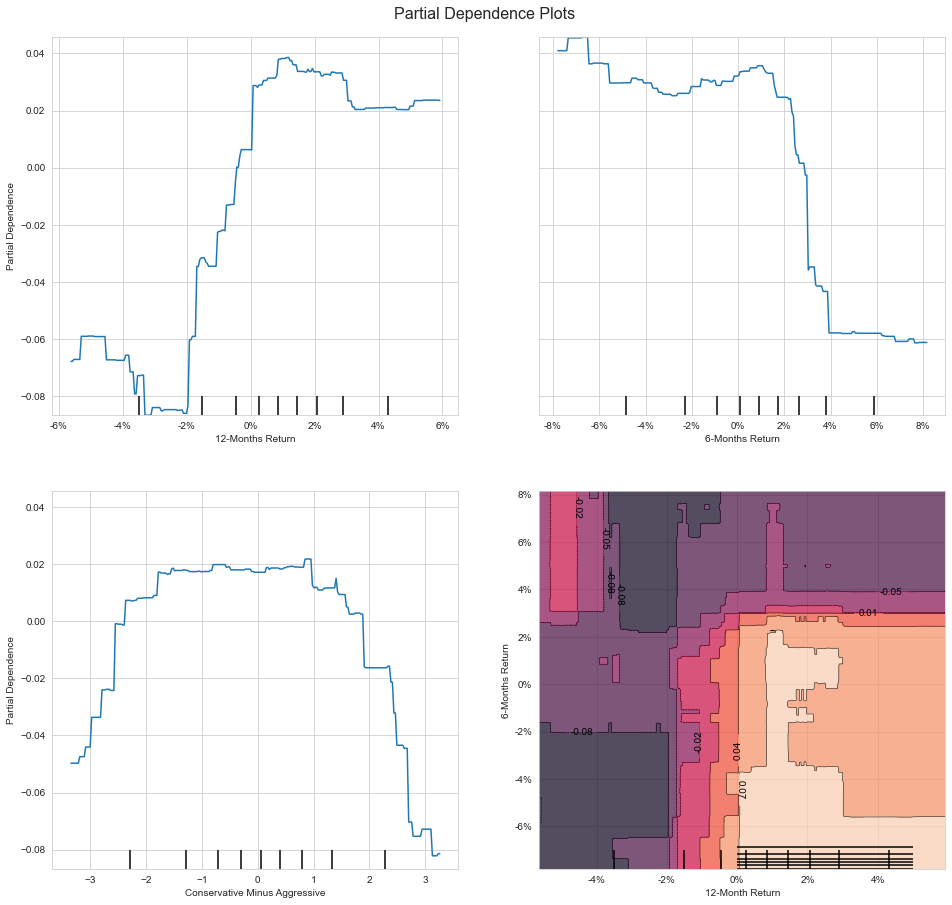

In [18]:
# 2D Partial Dependency
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 14))

X_ = features_clean
plot_partial_dependence(estimator=gb_clf, X=X_,
    features=['return_12m', 'return_6m', 'CMA', ('return_12m', 'return_6m')], percentiles=(0.05, 0.95),
    n_jobs=-1, n_cols=2, response_method='decision_function', grid_resolution=250, ax=axes)

for i, j in product([0, 1], repeat=2):
    if i!=1 or j!= 0:
        axes[i][j].xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

axes[1][1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

axes[0][0].set_ylabel('Partial Dependence')
axes[1][0].set_ylabel('Partial Dependence')
axes[0][0].set_xlabel('12-Months Return')
axes[0][1].set_xlabel('6-Months Return')
axes[1][0].set_xlabel('Conservative Minus Aggressive')

axes[1][1].set_xlabel('12-Month Return')
axes[1][1].set_ylabel('6-Months Return')
fig.suptitle('Partial Dependence Plots', fontsize=16)
fig.subplots_adjust(top=.95);

In [11]:
# 3D Partial Dependency
sns.set_style('whitegrid')
targets = ['return_12m', 'return_6m']
pdp, axes = partial_dependence(estimator=gb_clf, features=targets, X=X_, grid_resolution=100)

XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].reshape(list(map(np.size, axes))).T

fig = plt.figure(figsize=(14, 8))
ax = Axes3D(fig)
surface = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu, edgecolor='k')
ax.set_xlabel('12-Month Return')
ax.set_ylabel('6-Month Return')
ax.set_zlabel('Partial Dependence')
ax.view_init(elev=22, azim=30)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# fig.colorbar(surface)
fig.suptitle('Partial Dependence by 6- and 12-month Returns', fontsize=16)

Text(0.5, 0.98, 'Partial Dependence by 6- and 12-month Returns')

<Figure size 1008x576 with 0 Axes>

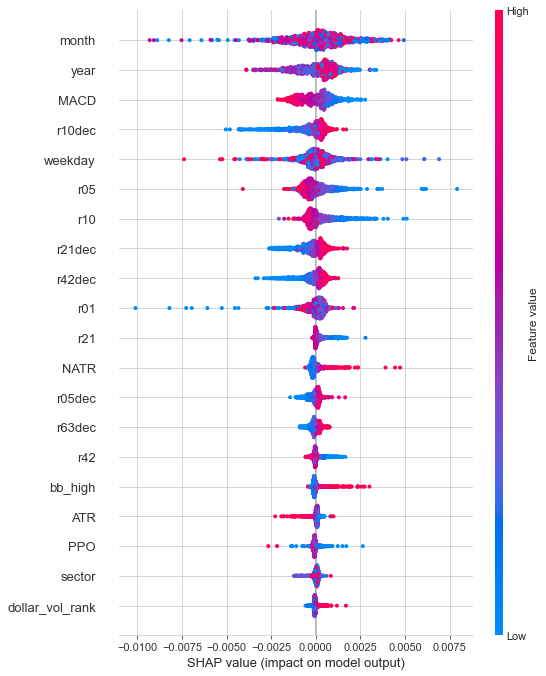

In [12]:
# SHAP Values
X = data[features].sample(n=1000)
# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X=X)

shap.summary_plot(shap_values, X, show=False)

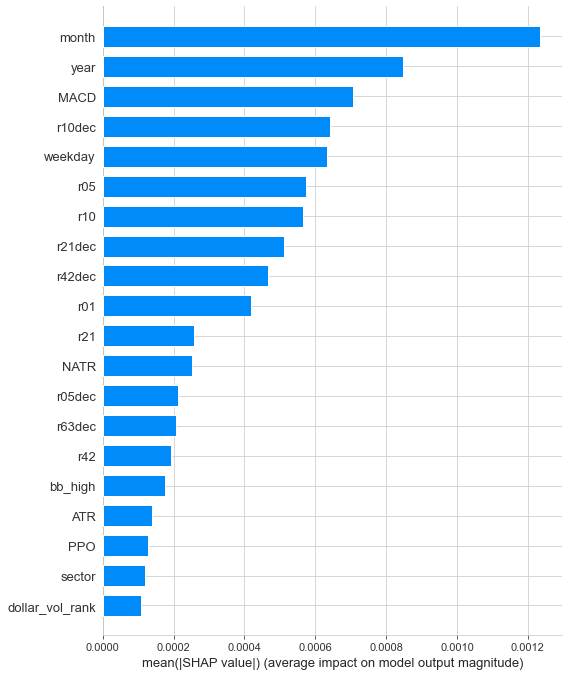

In [13]:
shap.summary_plot(shap_values, X, plot_type="bar",show=False)

In [14]:
# Force Plots
i = randint(0, len(X))
# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[i,:], X.iloc[i,:])

In [15]:
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X.iloc[:1000])

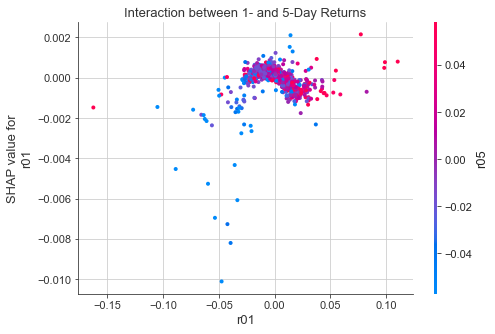

In [16]:
# Interaction Plot
shap.dependence_plot(ind='r01', shap_values=shap_values, features=X, interaction_index='r05',
                     title='Interaction between 1- and 5-Day Returns')